In [64]:
import numpy as np
import pandas as pd
import math

import scipy.stats as stats
import plotly.express as px
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from imblearn.over_sampling import SMOTE 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, matthews_corrcoef

from feature_engine.imputation.mean_median import MeanMedianImputer

import optuna

import shap

In [65]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [66]:
# Briefly inspect data
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [67]:
# Drop irrelevant columns
data = data.drop('id', axis=1)

In [68]:
# Check for null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [69]:
round(data.isnull().mean()*100, 2)

gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

In [70]:
# Missing data identified for bmi feature - to be imputed

In [71]:
# Inspect numerical variables for scaling and outliers
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [72]:
# Suggestive of outliers for avg_glucose_level and bmi features.

In [73]:
# Seperate numerical and categorical data
cat_data = data.select_dtypes(include='O')
num_data = data.select_dtypes(include=['int64', 'float64'])
cat_cols = cat_data.columns
num_cols = num_data.columns

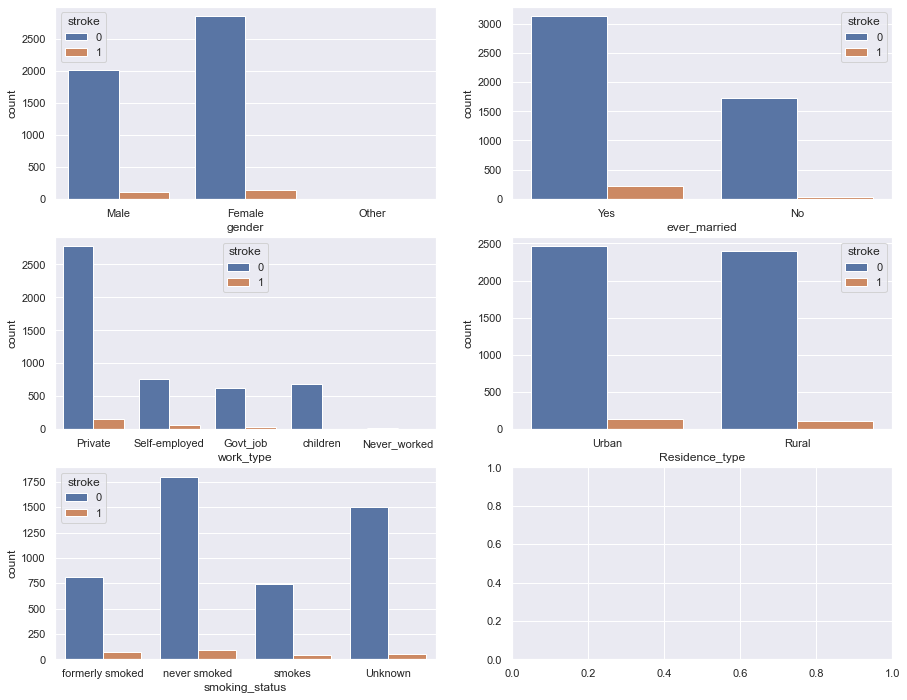

In [74]:
# Plot categorical data
n = len(cat_cols)

fig, ax = plt.subplots(math.ceil(n/2), 2, figsize=(15,12), sharey=False)
axes = ax.flatten()

for i in range(n):
  sns.countplot(data=data, x=cat_cols[i], hue='stroke', ax=axes[i])

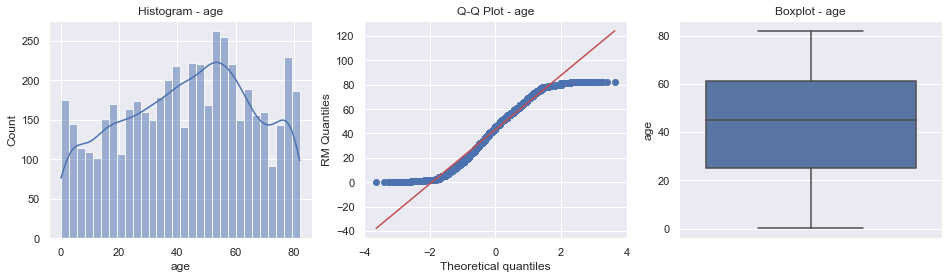

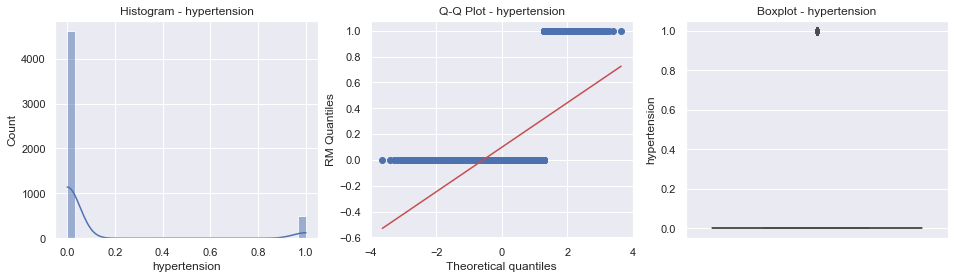

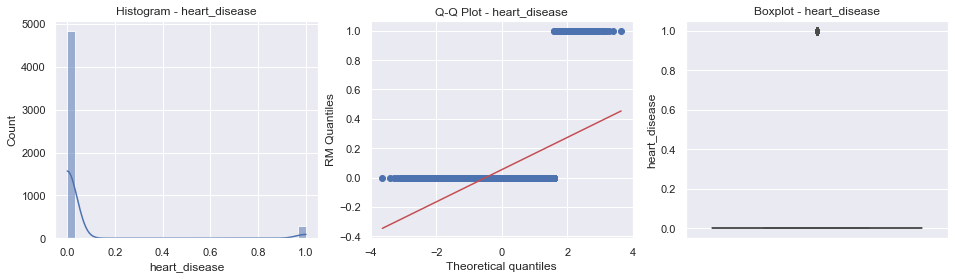

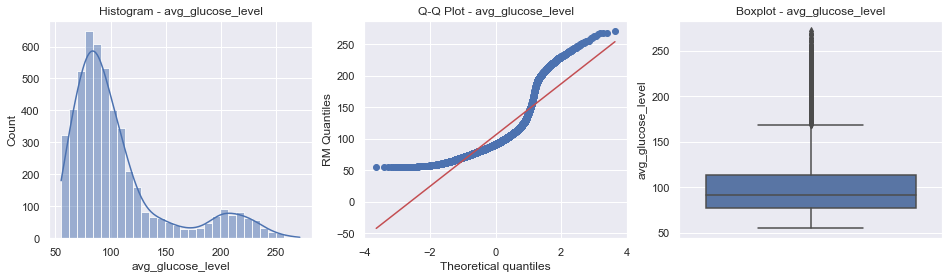

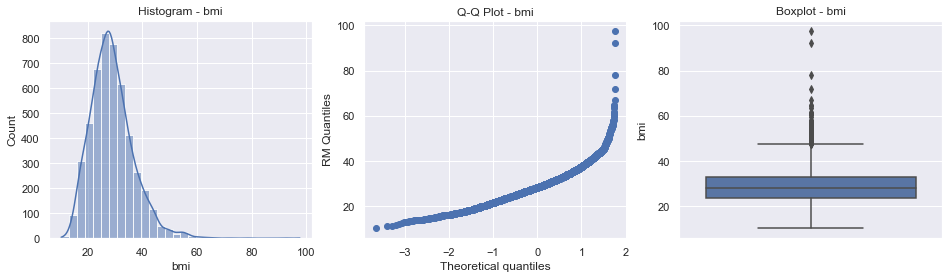

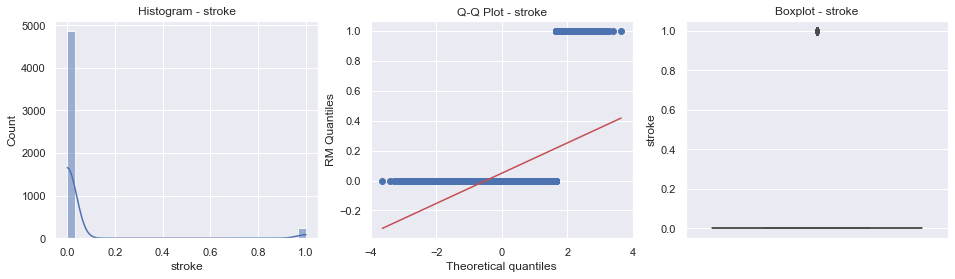

In [75]:
# Plot numerical data to explore distributions and identify outliers 

def diagnostic_plots(df, variable):
  plt.figure(figsize=(16,4))

  plt.subplot(1,3,1)
  sns.histplot(df[variable], bins=30, kde=True)
  plt.title(f'Histogram - {variable}')

  plt.subplot(1,3,2)
  stats.probplot(df[variable], dist='norm', plot=plt)
  plt.ylabel('RM Quantiles')
  plt.title(f'Q-Q Plot - {variable}')

  plt.subplot(1,3,3)
  sns.boxplot(y=df[variable])
  plt.title(f'Boxplot - {variable}')

  plt.show()

for i in range(len(num_cols)):
  diagnostic_plots(num_data, num_cols[i]) 

In [76]:
px.box(data, x=data['stroke'], y=data['bmi'], width=400, height=300)

In [77]:
px.box(data, x=data['stroke'], y=data['avg_glucose_level'], width=400, height=300)

In [78]:
# No evidence from data that outliers should be omitted - to retain

<AxesSubplot:>

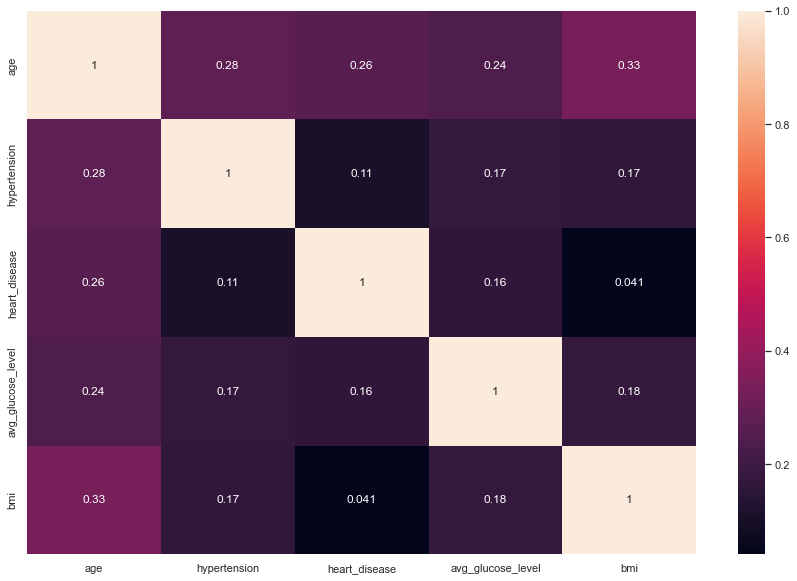

In [79]:
# Check for multicollinearity
fig = plt.figure(figsize=(15,10))
sns.heatmap(data.iloc[:,:-1].corr(), annot=True)

In [80]:
# To proceed with categorical encoding
# To binary encode Residence_type and ever_married and to one-hot encode remainder

In [81]:
data_encoded = data.copy()
data_encoded['Residence_type'] = data['Residence_type'].astype('category').cat.codes
data_encoded['ever_married'] = data['ever_married'].astype('category').cat.codes

In [82]:
data_encoded = pd.get_dummies(data_encoded)

In [83]:
data_encoded

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,1,0,202.21,NaN,1,1,0,0,0,0,0,1,0,0,0,1,0
2,80.0,0,1,1,0,105.92,32.5,1,0,1,0,0,0,1,0,0,0,0,1,0
3,49.0,0,0,1,1,171.23,34.4,1,1,0,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,1,0,174.12,24.0,1,1,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,1,1,83.75,NaN,0,1,0,0,0,0,1,0,0,0,0,1,0
5106,81.0,0,0,1,1,125.20,40.0,0,1,0,0,0,0,0,1,0,0,0,1,0
5107,35.0,0,0,1,0,82.99,30.6,0,1,0,0,0,0,0,1,0,0,0,1,0
5108,51.0,0,0,1,0,166.29,25.6,0,0,1,0,0,0,1,0,0,0,1,0,0


In [84]:
# To impute missing values for bmi

In [85]:
mean_imputer = MeanMedianImputer(imputation_method='mean', variables='bmi')

data_encoded = mean_imputer.fit_transform(data_encoded)

In [86]:
round(data_encoded['stroke'].value_counts()/data_encoded.shape[0]*100,2)

0    95.13
1     4.87
Name: stroke, dtype: float64

In [87]:
# Target variable significantly imbalanced
# To apply SMOTE

In [88]:
y = data_encoded.pop('stroke')
X = data_encoded

In [89]:
oversampler = SMOTE()
X,y = oversampler.fit_resample(X, y)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
# Scale date

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

Model:  Logistic Regression
Accuracy score: 0.944987146529563
Recall score: 0.8958762886597939
Precision score: 0.9931428571428571
F1 score: 0.9420054200542005
Matthew's coeff: 0.8942249952737443


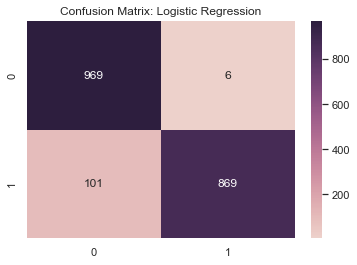

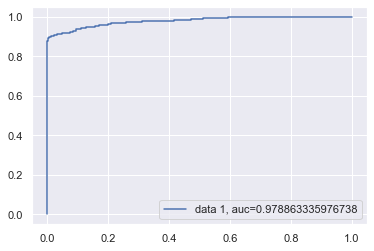

Model:  Random Forest
Accuracy score: 0.9624678663239075
Recall score: 0.9309278350515464
Precision score: 0.9933993399339934
F1 score: 0.9611495476317191
Matthew's coeff: 0.9267486488448713


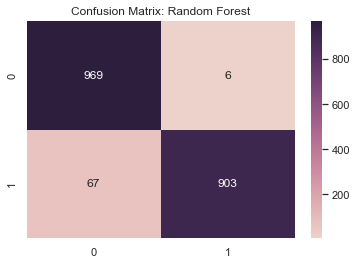

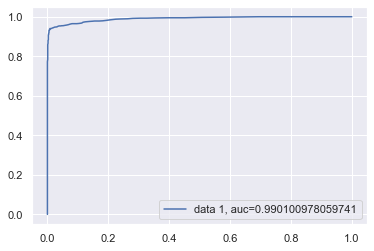

Model:  Naive Bayes
Accuracy score: 0.6349614395886889
Recall score: 0.9814432989690721
Precision score: 0.5790754257907542
F1 score: 0.7283856159143075
Matthew's coeff: 0.3756152308731879


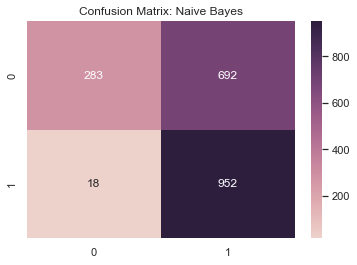

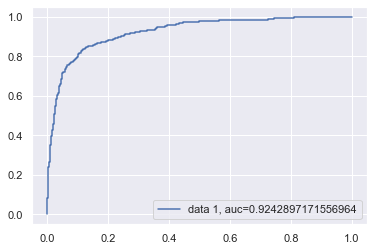

Model:  KNN
Accuracy score: 0.9619537275064267
Recall score: 0.945360824742268
Precision score: 0.9776119402985075
F1 score: 0.9612159329140462
Matthew's coeff: 0.9244011809493323


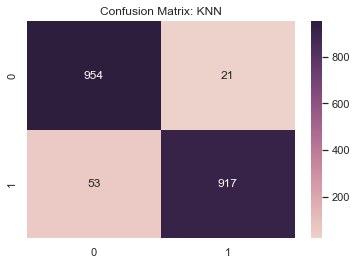

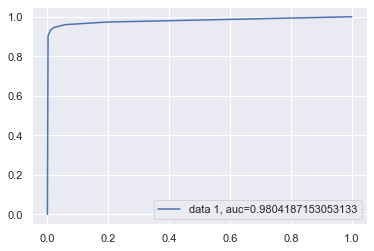

Model:  Support Vector Classifier
Accuracy score: 0.9413881748071979
Recall score: 0.8855670103092783
Precision score: 0.9965197215777262
F1 score: 0.9377729257641921
Matthew's coeff: 0.8882396374344991


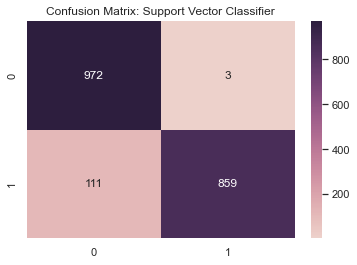

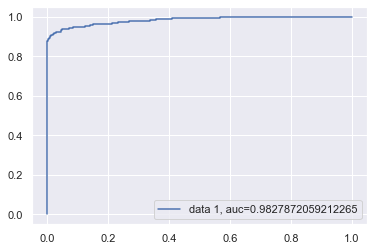

Model:  XG Boost
Accuracy score: 0.9537275064267352
Recall score: 0.9206185567010309
Precision score: 0.9856512141280354
F1 score: 0.9520255863539444
Matthew's coeff: 0.9094108682578564


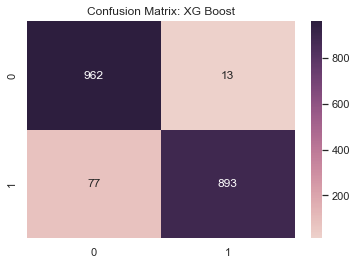

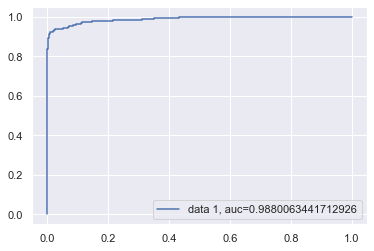

Model:  LGBM
Accuracy score: 0.9521850899742931
Recall score: 0.9164948453608247
Precision score: 0.9866814650388457
F1 score: 0.9502939604489578
Matthew's coeff: 0.9066378843362897


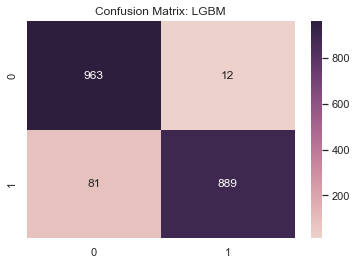

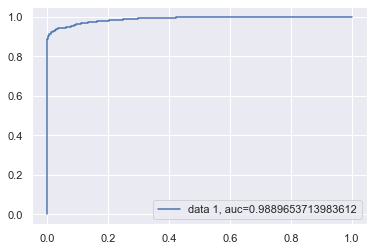

Model:  Cat Boost
Accuracy score: 0.9557840616966581
Recall score: 0.9247422680412372
Precision score: 0.9857142857142858
F1 score: 0.9542553191489362
Matthew's coeff: 0.913293960371563


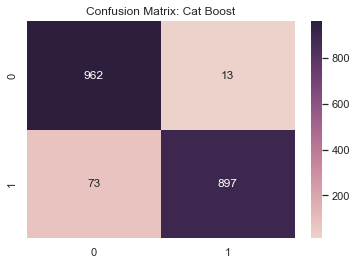

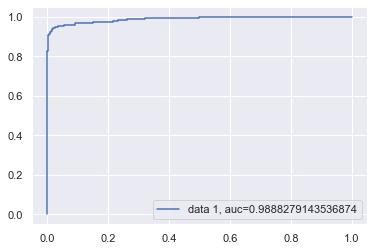

In [92]:
# To apply several models to data to get feel for performance
models = [('Logistic Regression', LogisticRegression()),
          ('Random Forest', RandomForestClassifier()),
          ('Naive Bayes', GaussianNB()),
          ('KNN', KNeighborsClassifier()),
          ('Support Vector Classifier', SVC(probability = True)),
          ('XG Boost', XGBClassifier()),
          ('LGBM', LGBMClassifier()),
          ('Cat Boost', CatBoostClassifier(logging_level = 'Silent'))]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Model: ",name)
    print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
    print(f'Recall score: {recall_score(y_test, y_pred)}')
    print(f'Precision score: {precision_score(y_test, y_pred)}')
    print(f'F1 score: {f1_score(y_test, y_pred)}')
    print(f'Matthew\'s coeff: {matthews_corrcoef(y_test, y_pred)}')

    plt.figure()
    cf_matrix = confusion_matrix(y_test, y_pred)
    plt.title(f'Confusion Matrix: {name}')
    sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
    plt.show()

    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

Model:  Logistic Regression
Accuracy score: 0.9439588688946016
Recall score: 0.8958762886597939
Precision score: 0.9908779931584949
F1 score: 0.9409853817000541
Matthew's coeff: 0.8919794773916608


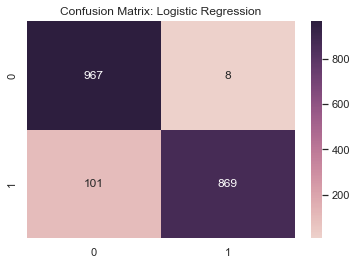

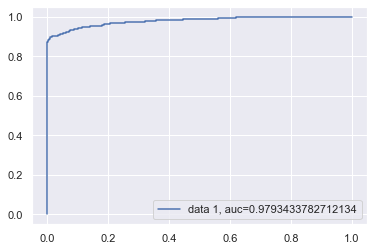

Model:  Random Forest
Accuracy score: 0.9645244215938303
Recall score: 0.9371134020618557
Precision score: 0.9912758996728462
F1 score: 0.9634340222575518
Matthew's coeff: 0.9304215933614561


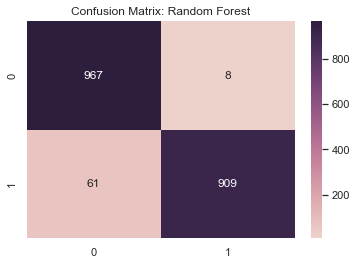

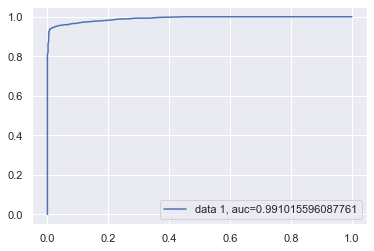

Model:  Naive Bayes
Accuracy score: 0.6339331619537275
Recall score: 0.9814432989690721
Precision score: 0.5783718104495748
F1 score: 0.72782874617737
Matthew's coeff: 0.3737967807872278


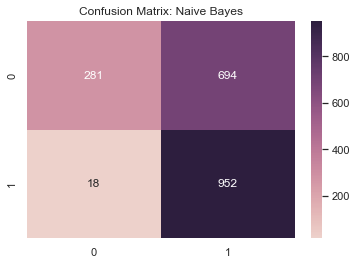

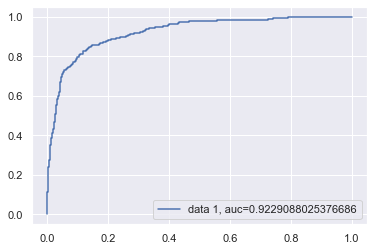

Model:  KNN
Accuracy score: 0.961439588688946
Recall score: 0.9494845360824742
Precision score: 0.9725448785638859
F1 score: 0.9608763693270735
Matthew's coeff: 0.9231322222521708


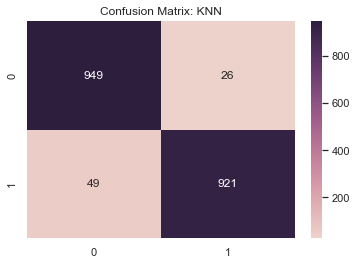

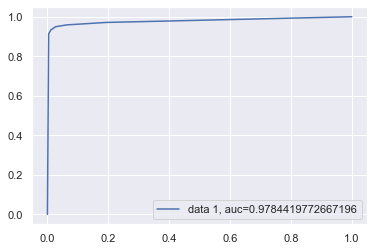

Model:  Support Vector Classifier
Accuracy score: 0.9388174807197943
Recall score: 0.8855670103092783
Precision score: 0.9907727797001153
F1 score: 0.9352204681545999
Matthew's coeff: 0.8825676567689428


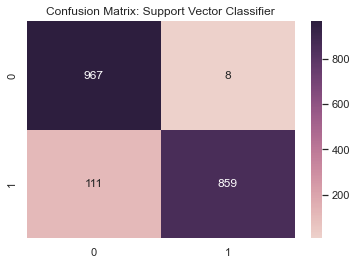

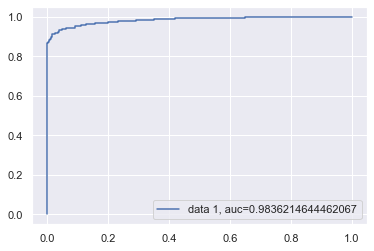

Model:  XG Boost
Accuracy score: 0.9547557840616967
Recall score: 0.9237113402061856
Precision score: 0.9846153846153847
F1 score: 0.9531914893617022
Matthew's coeff: 0.911233138002995


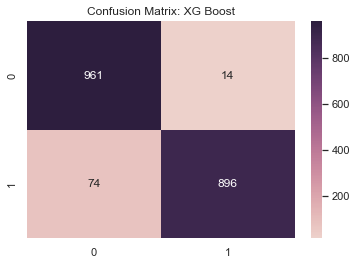

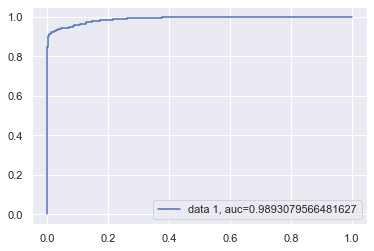

Model:  LGBM
Accuracy score: 0.9537275064267352
Recall score: 0.9175257731958762
Precision score: 0.9888888888888889
F1 score: 0.9518716577540107
Matthew's coeff: 0.9097980899382561


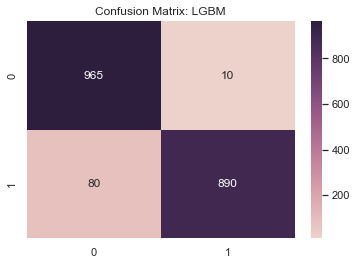

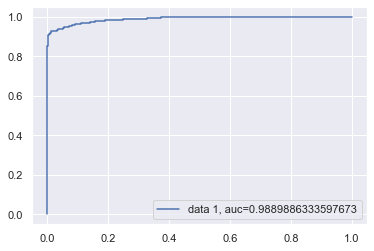

Model:  Cat Boost
Accuracy score: 0.9583547557840617
Recall score: 0.9278350515463918
Precision score: 0.9879253567508233
F1 score: 0.9569377990430622
Matthew's coeff: 0.9183882115946932


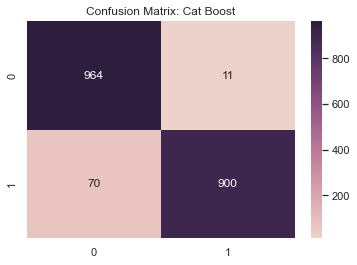

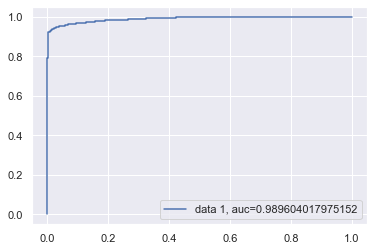

In [33]:
# To apply several models to data to get feel for performance
models = [('Logistic Regression', LogisticRegression()),
          ('Random Forest', RandomForestClassifier()),
          ('Naive Bayes', GaussianNB()),
          ('KNN', KNeighborsClassifier()),
          ('Support Vector Classifier', SVC(probability = True)),
          ('XG Boost', XGBClassifier()),
          ('LGBM', LGBMClassifier()),
          ('Cat Boost', CatBoostClassifier(logging_level = 'Silent'))]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Model: ",name)
    print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
    print(f'Recall score: {recall_score(y_test, y_pred)}')
    print(f'Precision score: {precision_score(y_test, y_pred)}')
    print(f'F1 score: {f1_score(y_test, y_pred)}')
    print(f'Matthew\'s coeff: {matthews_corrcoef(y_test, y_pred)}')

    plt.figure()
    cf_matrix = confusion_matrix(y_test, y_pred)
    plt.title(f'Confusion Matrix: {name}')
    sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
    plt.show()

    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [100]:
# Hyperparameter tuning using Optuna
# Matthew's Corr Coeff used to compare models as want metric to be sensitive to ratio of TN to FN given distress of innaccurate diagnosis.
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    model_type = trial.suggest_categorical('model_type', 
                                           ['logistic_regression', 
                                            'random_forest',
                                            'knn',
                                            'svm',
                                            'xgboost',
                                            'lgbm',
                                            'catboost'])
    
    if model_type == 'logistic_regression':
        penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
        if penalty == 'l1':
            solver = 'saga'
        else:
            solver = 'lbfgs'
        regularization = trial.suggest_uniform('logistic-regularization', 0.01, 10)
        model = LogisticRegression(penalty=penalty, C=regularization, solver=solver)
      
    if model_type == 'random_forest':
        max_depth = trial.suggest_int('max_depth', 5, X_train.shape[1])
        max_features = trial.suggest_int('max_features', 1, 5)
        n_estimators = trial.suggest_int('n_estimators', 1, 20)
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        model = RandomForestClassifier(max_depth=max_depth, 
                                       max_features=max_features, 
                                       n_estimators=n_estimators, 
                                       criterion=criterion)
    
    if model_type == 'knn':
        metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
        n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
        model = KNeighborsClassifier(metric=metric,
                                     n_neighbors=n_neighbors)
    
    if model_type == 'svm':
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        degree = trial.suggest_discrete_uniform('degree', 1, 5, 1)
        model = SVC(kernel=kernel, 
                    C=regularization, 
                    degree=degree)

    if model_type == 'xgboost':
        max_depth = trial.suggest_int('max_depth', 1, 50)
        learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
        n_estimators = trial.suggest_int('n_estimators', 1, 100)
        colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.01, 1)
        model = XGBClassifier(max_depth=max_depth, 
                              learning_rate=learning_rate, 
                              n_estimators=n_estimators,
                              colsample_bytree=colsample_bytree)

    if model_type == 'lgbm':
        num_leaves = trial.suggest_int('num_leaves', 1, 500)
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 500)
        max_depth = trial.suggest_int('max_depth', 1, 500)
        learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
        model = LGBMClassifier(num_leaves=num_leaves, 
                               min_data_in_leaf=min_data_in_leaf,
                               max_depth=max_depth,
                               learning_rate=learning_rate)

    if model_type == 'catboost':
        learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
        max_depth = trial.suggest_int('max_depth', 1, 16)
        n_estimators = trial.suggest_int('n_estimators', 1, 1000)
        model = CatBoostClassifier(learning_rate=learning_rate,
                                   max_depth=max_depth, 
                                   n_estimators=n_estimators,
                                   logging_level = 'Silent')

    if trial.should_prune():
            raise optuna.TrialPruned()
            
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = matthews_corrcoef(y_test, y_pred)
    return score

In [101]:
if __name__ == '__main__':
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler()
    )
    study.optimize(objective, n_trials=100)

    print(f'Number of finished trials: {len(study.trials)}')

    print(f'Best trial:')
    trial = study.best_trial

    print(f'Value: {trial.value}')

    print('Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2022-11-14 15:29:29,192] A new study created in memory with name: no-name-580994c4-7e3b-4e9a-adf4-8cd2bc3cff94
[I 2022-11-14 15:29:29,288] Trial 0 finished with value: 0.9191439932247958 and parameters: {'model_type': 'random_forest', 'max_depth': 16, 'max_features': 3, 'n_estimators': 15, 'criterion': 'gini'}. Best is trial 0 with value: 0.9191439932247958.
[I 2022-11-14 15:29:29,640] Trial 1 finished with value: 0.869242141033405 and parameters: {'model_type': 'knn', 'metric': 'euclidean', 'n_neighbors': 48}. Best is trial 0 with value: 0.9191439932247958.
[I 2022-11-14 15:29:29,738] Trial 2 finished with value: 0.816137587411936 and parameters: {'model_type': 'random_forest', 'max_depth': 6, 'max_features': 4, 'n_estimators': 15, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9191439932247958.
[I 2022-11-14 15:29:29,806] Trial 3 finished with value: 0.9099261857615814 and parameters: {'model_type': 'lgbm', 'num_leaves': 248, 'min_data_in_leaf': 463, 'max_depth': 276, 'lea

[LightGBM] [Warning] min_data_in_leaf is set=463, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=463


[I 2022-11-14 15:29:30,273] Trial 5 finished with value: 0.9101971478147886 and parameters: {'model_type': 'knn', 'metric': 'euclidean', 'n_neighbors': 12}. Best is trial 0 with value: 0.9191439932247958.
[I 2022-11-14 15:29:31,426] Trial 6 finished with value: 0.9115052117247399 and parameters: {'model_type': 'catboost', 'learning_rate': 0.8079644221686885, 'max_depth': 6, 'n_estimators': 302}. Best is trial 0 with value: 0.9191439932247958.
[I 2022-11-14 15:29:31,791] Trial 7 finished with value: 0.8845012388343884 and parameters: {'model_type': 'knn', 'metric': 'euclidean', 'n_neighbors': 37}. Best is trial 0 with value: 0.9191439932247958.
[I 2022-11-14 15:29:32,058] Trial 8 finished with value: 0.8869163319241067 and parameters: {'model_type': 'xgboost', 'max_depth': 44, 'learning_rate': 0.6475823394414072, 'n_estimators': 77, 'colsample_bytree': 0.18041781840995436}. Best is trial 0 with value: 0.9191439932247958.
[I 2022-11-14 15:32:56,982] Trial 9 finished with value: 0.8849130

[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2022-11-14 15:34:29,021] Trial 20 finished with value: 0.9157210665989528 and parameters: {'model_type': 'lgbm', 'num_leaves': 493, 'min_data_in_leaf': 46, 'max_depth': 148, 'learning_rate': 0.23361565256200686}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:34:51,676] Trial 21 finished with value: 0.9312994649630482 and parameters: {'model_type': 'catboost', 'learning_rate': 0.015594136300765282, 'max_depth': 10, 'n_estimators': 991}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:35:13,247] Trial 22 finished with value: 0.927280261966216 and parameters: {'model_type': 'catboost', 'learning_rate': 0.12096819411419014, 'max_depth': 10, 'n_estimators': 961}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:35:22,508] Trial 23 finished with value: 0.9311106221692717 and parameters: {'model_type': 'catboost', 'learning_rate': 0.15096641573269207, 'max_depth': 9, 'n_estimators': 773}. Best is trial 15 with value: 0.9325880146726807

[LightGBM] [Warning] min_data_in_leaf is set=271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=271


[I 2022-11-14 15:37:21,001] Trial 30 finished with value: 0.9003570212493023 and parameters: {'model_type': 'svm', 'kernel': 'rbf', 'svm-regularization': 2.783892197388578, 'degree': 5.0}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:37:29,986] Trial 31 finished with value: 0.9283616740668647 and parameters: {'model_type': 'catboost', 'learning_rate': 0.015315928635766496, 'max_depth': 9, 'n_estimators': 751}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:37:33,838] Trial 32 finished with value: 0.9273841599277093 and parameters: {'model_type': 'catboost', 'learning_rate': 0.16679353830041804, 'max_depth': 8, 'n_estimators': 471}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:37:53,824] Trial 33 finished with value: 0.9321859562511849 and parameters: {'model_type': 'catboost', 'learning_rate': 0.09252839662447539, 'max_depth': 10, 'n_estimators': 896}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:37:54,15

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2022-11-14 15:38:52,312] Trial 40 finished with value: 0.9201219968884987 and parameters: {'model_type': 'lgbm', 'num_leaves': 490, 'min_data_in_leaf': 55, 'max_depth': 75, 'learning_rate': 0.08399762493344146}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:39:01,199] Trial 41 finished with value: 0.9293400610862758 and parameters: {'model_type': 'catboost', 'learning_rate': 0.01271814399590418, 'max_depth': 9, 'n_estimators': 757}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:39:19,627] Trial 42 finished with value: 0.9322804874375824 and parameters: {'model_type': 'catboost', 'learning_rate': 0.1942063287122942, 'max_depth': 10, 'n_estimators': 887}. Best is trial 15 with value: 0.9325880146726807.
[I 2022-11-14 15:39:38,975] Trial 43 finished with value: 0.9292398995768287 and parameters: {'model_type': 'catboost', 'learning_rate': 0.08473862256047161, 'max_depth': 10, 'n_estimators': 896}. Best is trial 15 with value: 0.9325880146726807.


[LightGBM] [Warning] min_data_in_leaf is set=492, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=492


[I 2022-11-14 15:43:57,179] Trial 65 finished with value: 0.9218897997168793 and parameters: {'model_type': 'catboost', 'learning_rate': 0.26596758344827354, 'max_depth': 11, 'n_estimators': 879}. Best is trial 48 with value: 0.9341544272048635.
[I 2022-11-14 15:43:59,314] Trial 66 finished with value: 0.5240529195998234 and parameters: {'model_type': 'svm', 'kernel': 'sigmoid', 'svm-regularization': 5.822532541337917, 'degree': 3.0}. Best is trial 48 with value: 0.9341544272048635.
[I 2022-11-14 15:44:09,070] Trial 67 finished with value: 0.9156232509029442 and parameters: {'model_type': 'catboost', 'learning_rate': 0.7539855996105282, 'max_depth': 9, 'n_estimators': 932}. Best is trial 48 with value: 0.9341544272048635.
[I 2022-11-14 15:44:09,479] Trial 68 finished with value: 0.9060941167721146 and parameters: {'model_type': 'logistic_regression', 'penalty': 'l1', 'logistic-regularization': 5.908439507134932}. Best is trial 48 with value: 0.9341544272048635.
[I 2022-11-14 15:44:09,7

[LightGBM] [Warning] min_data_in_leaf is set=245, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=245


[I 2022-11-14 15:46:56,241] Trial 80 finished with value: 0.9197178038557513 and parameters: {'model_type': 'catboost', 'learning_rate': 0.012377129132985283, 'max_depth': 7, 'n_estimators': 347}. Best is trial 48 with value: 0.9341544272048635.
[I 2022-11-14 15:47:20,920] Trial 81 finished with value: 0.9320954076157614 and parameters: {'model_type': 'catboost', 'learning_rate': 0.04881343851570591, 'max_depth': 10, 'n_estimators': 966}. Best is trial 48 with value: 0.9341544272048635.
[I 2022-11-14 15:47:42,953] Trial 82 finished with value: 0.9244568269277688 and parameters: {'model_type': 'catboost', 'learning_rate': 0.1025326829677961, 'max_depth': 10, 'n_estimators': 879}. Best is trial 48 with value: 0.9341544272048635.
[I 2022-11-14 15:47:56,140] Trial 83 finished with value: 0.9293400610862758 and parameters: {'model_type': 'catboost', 'learning_rate': 0.04774587817887003, 'max_depth': 9, 'n_estimators': 992}. Best is trial 48 with value: 0.9341544272048635.
[I 2022-11-14 15:4

Number of finished trials: 100
Best trial:
Value: 0.9341544272048635
Params: 
    model_type: catboost
    learning_rate: 0.0932081219692829
    max_depth: 10
    n_estimators: 909


Model:  CatBoost
Accuracy Score: 0.9665809768637532
Recall score: 0.9412371134020618
Precision score: 0.991313789359392
F1 Score: 0.9656266525647805
Matthew's coeff: 0.9343399392622511


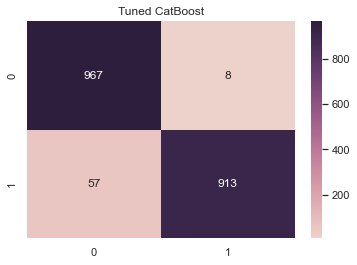

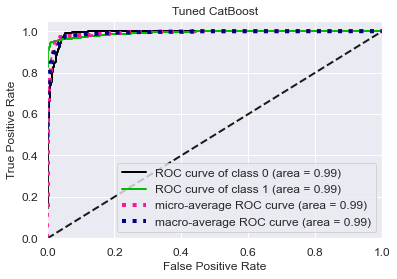

age: 12.52109188009
hypertension: 11.439837794576068
heart_disease: 9.821813034280918
ever_married: 9.13629861792991
Residence_type: 8.094015695810405
avg_glucose_level: 8.047730780238044
bmi: 7.1734518793244515
gender_Female: 6.595732372371207
gender_Male: 6.114141575141159
gender_Other: 5.768295507070234
work_type_Govt_job: 5.320102221568296
work_type_Never_worked: 3.5656821951783955
work_type_Private: 3.2391060012808626
work_type_Self-employed: 1.9478640335406314
work_type_children: 0.678911175217377
smoking_status_Unknown: 0.4969707558899239
smoking_status_formerly smoked: 0.03813552824634735
smoking_status_never smoked: 0.0008189522457879479
smoking_status_smokes: 0.0


In [89]:
name, model = ('CatBoost', CatBoostClassifier(max_depth=10,
                                              n_estimators=430,
                                              learning_rate=0.1278800286631269,
                                              logging_level = 'Silent'))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
print("Model: ",name)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'Precision score: {precision_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'Matthew\'s coeff: {matthews_corrcoef(y_test, y_pred)}')

plt.figure()
cf_matrix = confusion_matrix(y_test, y_pred)
plt.title(f'Tuned {name}')
sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
plt.show()
    
skplt.metrics.plot_roc(y_test, model.predict_proba(X_test))
plt.title(f'Tuned {name}')
plt.show()
    
print('Feature Importance:')
importance = sorted(model.feature_importances_, reverse=True)
for i,v in enumerate(importance):
  feature = X_train.columns[i]
  print(f'{feature}: {v}')

In [90]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [91]:
shap.initjs()

In [92]:
shap.force_plot(explainer.expected_value, shap_values[1], features=X_train.iloc[1])

In [93]:
shap.force_plot(explainer.expected_value, shap_values[20], features=X_train.iloc[20])

In [94]:
shap.force_plot(explainer.expected_value, shap_values[60], features=X_train.iloc[60])

In [95]:
shap.force_plot(explainer.expected_value, shap_values[:100], features=X_train.iloc[:100])

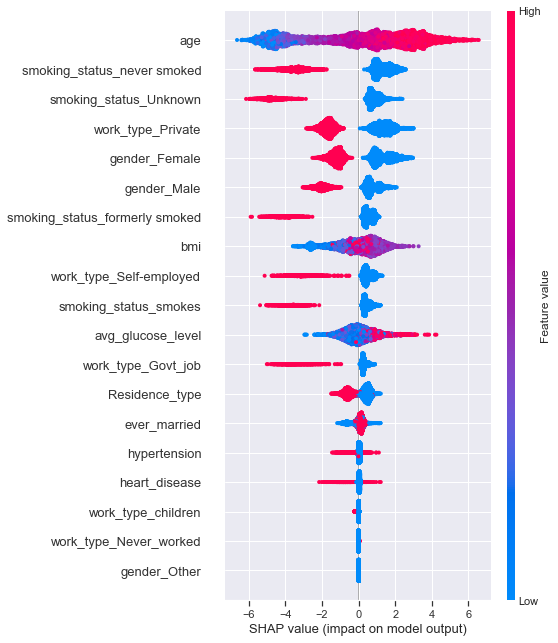

In [96]:
shap.summary_plot(shap_values, X_train)

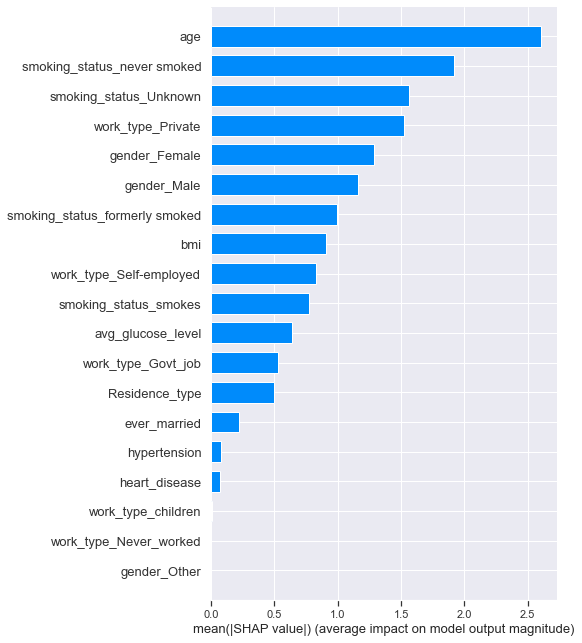

In [97]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

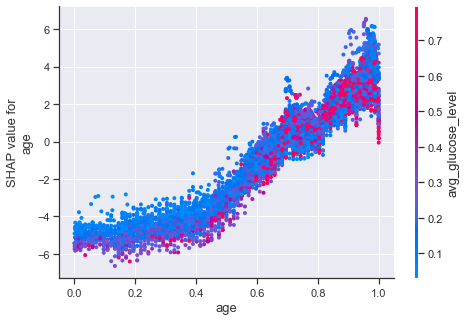

In [98]:
shap.dependence_plot('age', shap_values, X_train)

In [ ]:
# SHAP analysis indicates that 'age' has the highest positive correlation with stroke risk out of the variables evaluated. 